# Qubit Two Tone Frequency and Resonator Power Sweep

This experiment run a sweep in both Qubit Frequency and resonator Power. The VNA is used to track the changes at the read-out resonator and needs to be set at the frequency corresponding to the flux value used for the measurement.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from IPython.display import clear_output
from time import sleep

In [33]:
lo = SGS100A_driver('TCPIP0::192.168.0.38::inst0::INSTR')
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna.open()
lo.open()
f_c = 0    # Initial Frequency 


twpa_on = True
meas_ = 'S12'
if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.37::inst0::INSTR')
    twpa.open()

Update resonator frequency (after setting the flux current)

In [42]:
from datetime import datetime
params={}
params['twpa_on'] = twpa_on
params['twpa_power'] = -3.0
params['twpa_frequency'] = 6.78e3

if params['twpa_on']:
    twpa.set_RF(params['twpa_frequency'])
    twpa.set_level(params['twpa_power']) # dBm
    twpa.start_rf()
    
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'twotone_f_pres_sweep'

params['qubit_name'] = 'SpinQ_10q'
params['resonator_frequency'] = 7432750000.00 # 7511780000.00 
params['qubit_power'] = -30
params['vna_power'] = -100
params['temp'] = 17 #mK
params['comment'] = " Connected without RT amplifier. \n" +\
                    "# yes TWPA" +\
                    "# Connection Diagram: RO_in: L2-01, RO_out: L3-31 \n"
params['twpa_on']= twpa_on
# Sweep Parameters
#5.635640000000
params['qubitFreqInitial'] = 4100.
params['qubitFreqFinal'] = 4300.
params['qubitFreqStep'] = 5.

if params['twpa_on']:
    twpa.start_rf()

params['resonator_power_initial'] = -50
params['resonator_power_final'] = -80
params['resonator_power_step'] = -2

qubitFreq_array = np.arange(params['qubitFreqInitial'],params['qubitFreqFinal'],params['qubitFreqStep'])


# Check that the f of the resonator is correct 
if f_c == 0:
    freqs, mag, phase = meas_spectrum(vna, params['resonator_frequency'] ,f_span=20,power=params['vna_power'], npoints=201,sleep_t = 30, meas = 'S12')
    f_c, Qf, fwhm = Q(freqs, 0.4-mag, True)
    print('Center frequency: %2.2f Hz'%f_c)
    print('FWHM: %2.2f kHz'%(fwhm*1e-3))
    print('Quality Factor: %2.2f'%Qf)


res_power_array = np.arange(params['resonator_power_initial'],params['resonator_power_final'],params['resonator_power_step'])

#Initialize the VNA for the 2tone measurement
freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 3, 
                       sleep_t = 3)

maxv = np.mean(mag)
delay = 1

#Initialize the Local Oscillator
lo.set_level(params['qubit_power'] ) # dBm
lo.start_rf()

vna.set_power(res_power_array[0])
tt = (delay+1)*(len(res_power_array)*len(qubitFreq_array))/60.0
print('Estimated time for test = %2.2f min'%tt)

Estimated time for test = 20.00 min


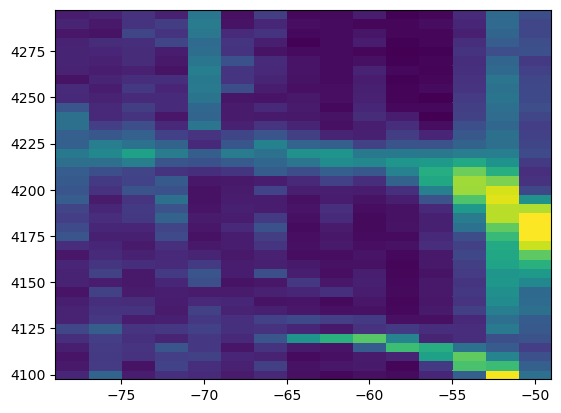

NameError: name 'path' is not defined

In [43]:
#Initialize variables for storage
mags = np.ndarray((len(qubitFreq_array),len(res_power_array)))
phases = np.ndarray((len(qubitFreq_array),len(res_power_array)))

mags[:] =maxv
phases[:] = 0

try:
    for idx_power, res_power in enumerate(res_power_array):
        # Re center at the resonator to check for shifts as the power changes
        freqs, mag, phase = meas_spectrum(vna, params['resonator_frequency'] ,f_span=10,power=res_power, npoints=201,sleep_t = 10, meas = 'S12')
        f_c, Qf, fwhm = Q(freqs,0.5-mag, True)


        #Initialize the VNA for the 2tone measurement
        freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = res_power,
                       npoints = 3, 
                       sleep_t = 3)

        for idx,qfreq in enumerate(qubitFreq_array):    
            clear_output(wait=True)
            lo.set_RF(qfreq)
            lo.start_rf()
            sleep(0.1)
            vna.reset_average()
            sleep(delay)
            mag, phase =  vna.get_data(meas = 'S12')
            lo.stop_rf()
            mags[idx,idx_power] = mag[1]
            phases[idx,idx_power] = phase[1]
            plt.pcolor(res_power_array,qubitFreq_array,mags)
            plt.show()
    Z = toComplex(mags,phases)
except KeyboardInterrupt:
    print("Stopped")
finally:
    lo.stop_rf()
    vna.stop_rf()

lo.stop_rf()
vna.stop_rf()

#Save
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
header_str = get_plot_str(params, filename)
np.savez(path + '/' + filename,
         header = header_str,
         freqs=qubitFreq_array,
         axis2 = res_power_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

file saved as twotone_f_pres_sweep_D28_CS05_20240208_0951


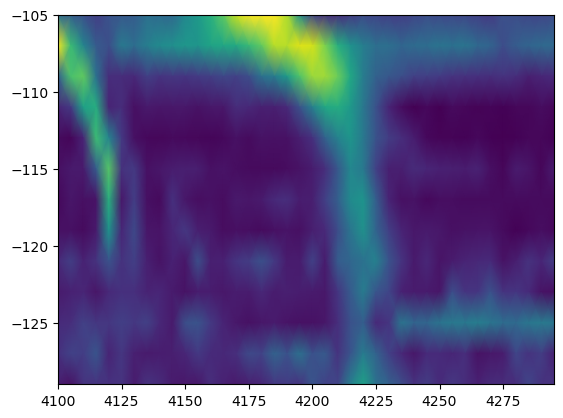

In [44]:
att = 55
plt.pcolormesh(qubitFreq_array,res_power_array[0:13]-att,np.transpose(mags[:,0:13]), 
               cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.show()

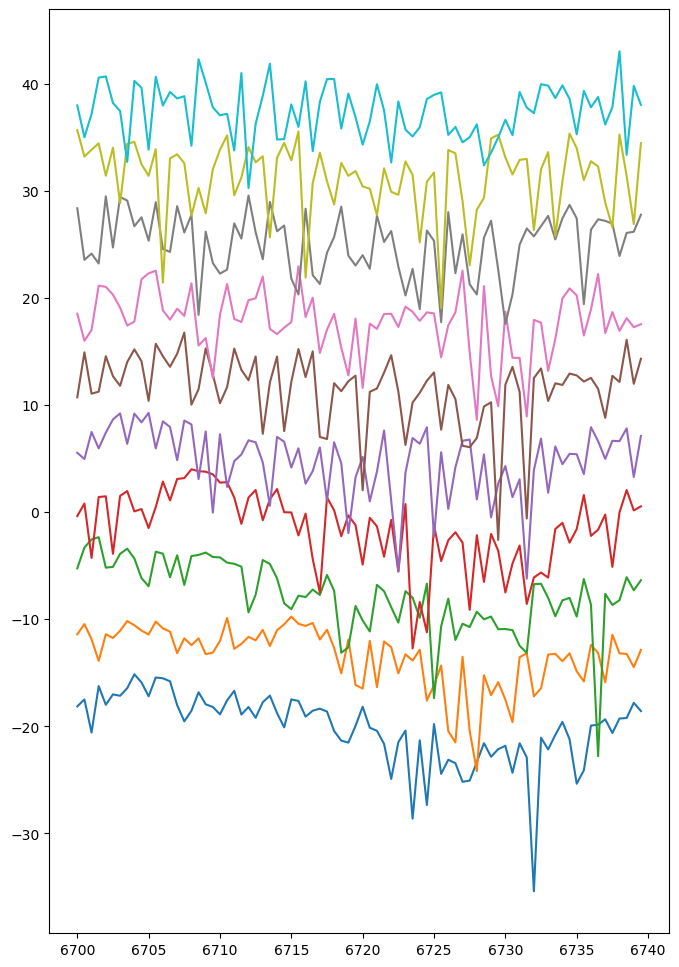

In [88]:
fig = plt.figure(figsize=( 8, 12))

for idx_power, res_power in enumerate(res_power_array[0:12]):
    plt.plot(qubitFreq_array,10*np.log10(mags[:,idx_power])+idx_power*6 )